### The performance of various CP scores and predictors for MINIST

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from torchcp.classification.loss import ConfTr
from torchcp.classification.predictors import SplitPredictor, ClassWisePredictor, ClusterPredictor
from torchcp.classification.scores import THR, APS, SAPS, RAPS
from torchcp.utils import fix_randomness

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

if __name__ == '__main__':
    alpha = 0.01
    num_trials = 5
    losses = ["THR", "APS", "SAPS", "RAPS"]
    predictors = ["SplitPredictor", "ClassWisePredictor", "ClusterPredictor"]
    results = {}

    for loss in losses:
        print(f"############################## {loss} #########################")

        for predictor_name in predictors:
            print(f"### Using {predictor_name} ###")

            # Instantiate the selected score function
            if loss == "THR":
                score_function = THR(score_type="log_softmax")
            elif loss == "APS":
                score_function = APS()
            elif loss == "SAPS":
                score_function = SAPS(weight=1.0)
            elif loss == "RAPS":
                score_function = RAPS(penalty=0.1, kreg=0)

            # Instantiate the selected predictor
            if predictor_name == "SplitPredictor":
                predictor = SplitPredictor(score_function)
            elif predictor_name == "ClassWisePredictor":
                predictor = ClassWisePredictor(score_function)
            elif predictor_name == "ClusterPredictor":
                predictor = ClusterPredictor(score_function)
        
            criterion = ConfTr(weight=0.01,
                               predictor=predictor,
                               alpha=0.05,
                               fraction=0.5,
                               loss_type="valid",
                               base_loss_fn=nn.CrossEntropyLoss())

            fix_randomness(seed=0)

            # Training a pytorch model
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
            ])

            train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
            train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True, pin_memory=True)

            test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
            cal_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [5000, 5000])
            cal_data_loader = torch.utils.data.DataLoader(cal_dataset, batch_size=1600, shuffle=False, pin_memory=True)
            test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1600, shuffle=False, pin_memory=True)

            model = Net().to(device)
            optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

            for epoch in range(1, 10):
                train(model, device, train_data_loader, criterion, optimizer, epoch)

            # Set the model for the predictor
            predictor._model = model

            predictor.calibrate(cal_data_loader, alpha)
            result = predictor.evaluate(test_data_loader)
            print(f"Result--Coverage_rate: {result['Coverage_rate']}, Average_size: {result['Average_size']}")

            # Store the result
            results[f"{loss}_{predictor_name}"] = result


############################## THR #########################
### Using SplitPredictor ###


100%|██████████| 9912422/9912422 [00:00<00:00, 56463498.31it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 46716426.47it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 19812844.74it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16755082.47it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Result--Coverage_rate: 0.9922, Average_size: 2.2696
### Using ClassWisePredictor ###


/data/lab/STA303-Assignment04/TorchCP/torchcp/classification/predictors/split.py:67: UserWarning: The value of quantile exceeds 1. It should be a value in (0,1). To avoid program crash, the threshold is set as torch.inf.
  warnings.warn(
/data/lab/STA303-Assignment04/TorchCP/torchcp/classification/predictors/split.py:61: UserWarning: The number of scores is 0, which is a invalid scores. To avoid program crash, the threshold is set as torch.inf.
  warnings.warn(


Result--Coverage_rate: 0.991, Average_size: 2.4724
### Using ClusterPredictor ###
Result--Coverage_rate: 0.9918, Average_size: 2.2206
############################## APS #########################
### Using SplitPredictor ###
Result--Coverage_rate: 0.9918, Average_size: 2.848
### Using ClassWisePredictor ###
Result--Coverage_rate: 0.9896, Average_size: 2.8056
### Using ClusterPredictor ###
Result--Coverage_rate: 0.9906, Average_size: 2.7012
############################## SAPS #########################
### Using SplitPredictor ###
Result--Coverage_rate: 0.9928, Average_size: 4.2508
### Using ClassWisePredictor ###
Result--Coverage_rate: 0.9928, Average_size: 4.2948
### Using ClusterPredictor ###
Result--Coverage_rate: 0.9924, Average_size: 4.1488
############################## RAPS #########################
### Using SplitPredictor ###
Result--Coverage_rate: 0.9916, Average_size: 4.0446
### Using ClassWisePredictor ###
Result--Coverage_rate: 0.9916, Average_size: 3.8156
### Using ClusterP

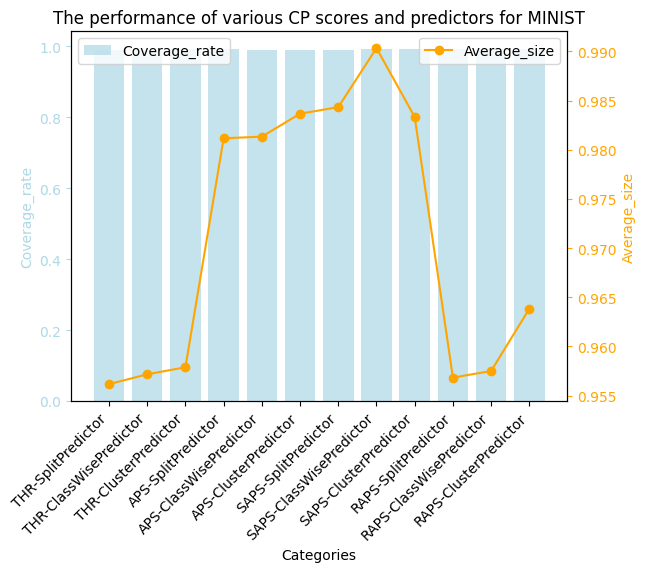

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# 生成一些示例数据
categories = ['THR-SplitPredictor', 'THR-ClassWisePredictor', 'THR-ClusterPredictor', 'APS-SplitPredictor', 'APS-ClassWisePredictor', 'APS-ClusterPredictor', 'SAPS-SplitPredictor', 'SAPS-ClassWisePredictor', 'SAPS-ClusterPredictor', 'RAPS-SplitPredictor',
              'RAPS-ClassWisePredictor', 'RAPS-ClusterPredictor']
bar_data = [0.991,  0.991, 0.9918, 0.9918, 0.9896,0.9896,0.9906,0.9928,0.9928, 0.9916,0.9916,0.9918]
line_data = [0.956167,  0.957167, 0.957883, 0.981167, 0.981333,0.983667,0.984333,0.990333,0.983333, 0.956833,0.957500, 0.963833]

# 创建柱状图
fig, ax1 = plt.subplots()

# 绘制柱状图
ax1.bar(categories, bar_data, color='lightblue', alpha=0.7, label='Coverage_rate')
ax1.set_xlabel('Categories')
plt.xticks(rotation=45, ha='right') 
ax1.set_ylabel('Coverage_rate', color='lightblue')
ax1.tick_params('y', colors='lightblue')

# 创建第二个坐标轴对象
ax2 = ax1.twinx()

# 绘制折线图
ax2.plot(categories, line_data, color='orange', marker='o', label='Average_size')
ax2.set_ylabel('Average_size', color='orange')
ax2.tick_params('y', colors='orange')


# 显示图例
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# 设置标题
plt.title('The performance of various CP scores and predictors for MINIST')

# 显示图形
plt.show()



### The performance of various CP scores and predictors for CIFAR-10

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from examples.common.dataset import build_dataset
from torchcp.classification.loss import ConfTr
from torchcp.classification.predictors import SplitPredictor, ClassWisePredictor, ClusterPredictor, WeightedPredictor
from torchcp.classification.scores import THR, APS, SAPS, RAPS
from torchcp.utils import fix_randomness

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

if __name__ == '__main__':
    alpha = 0.01
    num_trials = 5
    losses = ["THR", "APS", "SAPS", "RAPS"]
    predictors = ["SplitPredictor", "ClassWisePredictor", "ClusterPredictor"]
    results = {}

    for loss in losses:
        print(f"############################## {loss} #########################")

        for predictor_name in predictors:
            print(f"### Using {predictor_name} ###")

            # Instantiate the selected score function
            if loss == "THR":
                score_function = THR(score_type="log_softmax")
            elif loss == "APS":
                score_function = APS()
            elif loss == "SAPS":
                score_function = SAPS(weight=1.0)
            elif loss == "RAPS":
                score_function = RAPS(penalty=0.1, kreg=0)

            # Instantiate the selected predictor
            if predictor_name == "SplitPredictor":
                predictor = SplitPredictor(score_function)
            elif predictor_name == "ClassWisePredictor":
                predictor = ClassWisePredictor(score_function)
            elif predictor_name == "ClusterPredictor":
                predictor = ClusterPredictor(score_function)
        

            criterion = ConfTr(weight=0.01,
                               predictor=predictor,
                               alpha=0.05,
                               fraction=0.5,
                               loss_type="valid",
                               base_loss_fn=nn.CrossEntropyLoss())

            fix_randomness(seed=0)

            # Training a pytorch model
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            train_dataset = build_dataset("mnist")
            train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True, pin_memory=True)
            test_dataset = build_dataset("mnist", mode='test')
            cal_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [5000, 5000])
            cal_data_loader = torch.utils.data.DataLoader(cal_dataset, batch_size=1600, shuffle=False, pin_memory=True)
            test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1600, shuffle=False, pin_memory=True)

            model = Net().to(device)
            optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

            for epoch in range(1, 10):
                train(model, device, train_data_loader, criterion, optimizer, epoch)

            # Set the model for the predictor
            predictor._model = model

            predictor.calibrate(cal_data_loader, alpha)
            result = predictor.evaluate(test_data_loader)
            print(f"Result--Coverage_rate: {result['Coverage_rate']}, Average_size: {result['Average_size']}")

            # Store the result
            results[f"{loss}_{predictor_name}"] = result


############################## THR #########################
### Using SplitPredictor ###
Result--Coverage_rate: 0.9922, Average_size: 1.7656
### Using ClassWisePredictor ###
Result--Coverage_rate: 0.9918, Average_size: 1.967
### Using ClusterPredictor ###
Result--Coverage_rate: 0.992, Average_size: 1.7496
############################## APS #########################
### Using SplitPredictor ###
Result--Coverage_rate: 0.9932, Average_size: 2.4546
### Using ClassWisePredictor ###
Result--Coverage_rate: 0.991, Average_size: 2.4998
### Using ClusterPredictor ###
Result--Coverage_rate: 0.9896, Average_size: 2.2972
############################## SAPS #########################
### Using SplitPredictor ###
Result--Coverage_rate: 0.9926, Average_size: 3.5062
### Using ClassWisePredictor ###
Result--Coverage_rate: 0.9924, Average_size: 3.4586
### Using ClusterPredictor ###
Result--Coverage_rate: 0.9926, Average_size: 3.4972
############################## RAPS #########################
### Using 

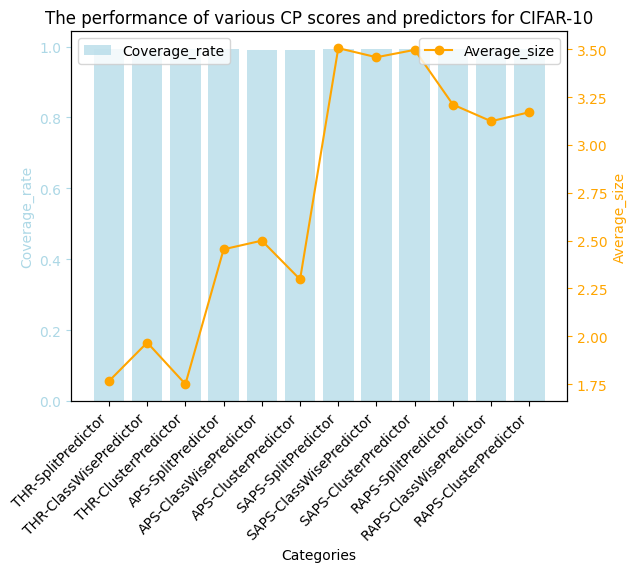

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# 生成一些示例数据
categories = ['THR-SplitPredictor', 'THR-ClassWisePredictor', 'THR-ClusterPredictor', 'APS-SplitPredictor', 'APS-ClassWisePredictor', 'APS-ClusterPredictor', 'SAPS-SplitPredictor', 'SAPS-ClassWisePredictor', 'SAPS-ClusterPredictor', 'RAPS-SplitPredictor',
              'RAPS-ClassWisePredictor', 'RAPS-ClusterPredictor']
bar_data = [0.9922,  0.9918, 0.992, 0.9932, 0.991,0.9896,0.9926,0.9924,0.9926,0.9934,0.9908,0.9932]
line_data = [1.7656, 1.967, 1.7496, 2.4546, 2.4998,2.2972,3.5062,3.4586,3.4972,3.2112,3.124,3.1712]

# 创建柱状图
fig, ax1 = plt.subplots()

# 绘制柱状图
ax1.bar(categories, bar_data, color='lightblue', alpha=0.7, label='Coverage_rate')
ax1.set_xlabel('Categories')
plt.xticks(rotation=45, ha='right')
ax1.set_ylabel('Coverage_rate', color='lightblue')
ax1.tick_params('y', colors='lightblue')

# 创建第二个坐标轴对象
ax2 = ax1.twinx()

# 绘制折线图
ax2.plot(categories, line_data, color='orange', marker='o', label='Average_size')
ax2.set_ylabel('Average_size', color='orange')
ax2.tick_params('y', colors='orange')

# 显示图例
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# 设置标题
plt.title('The performance of various CP scores and predictors for CIFAR-10')
# 显示图形
plt.show()


### Comparision

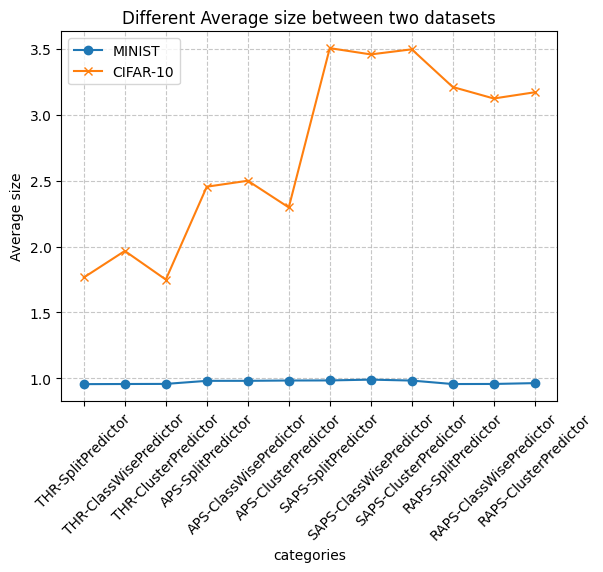

In [53]:
import matplotlib.pyplot as plt

# 示例数据
x = ['THR-SplitPredictor', 'THR-ClassWisePredictor', 'THR-ClusterPredictor', 'APS-SplitPredictor', 'APS-ClassWisePredictor', 'APS-ClusterPredictor', 'SAPS-SplitPredictor', 'SAPS-ClassWisePredictor', 'SAPS-ClusterPredictor', 'RAPS-SplitPredictor',
              'RAPS-ClassWisePredictor', 'RAPS-ClusterPredictor']
y1_values = [0.956167,  0.957167, 0.957883, 0.981167, 0.981333,0.983667,0.984333,0.990333,0.983333, 0.956833,0.957500, 0.963833]
y2_values = [1.7656, 1.967, 1.7496, 2.4546, 2.4998,2.2972,3.5062,3.4586,3.4972,3.2112,3.124,3.1712]

# 第一条折线图
plt.plot(x, y1_values, label='MINIST', marker='o')

# 第二条折线图
plt.plot(x, y2_values, label='CIFAR-10', marker='x')

# 设置图例
plt.legend()

# 设置标题和标签
plt.title('Different Average size between two datasets')
plt.xlabel('categories')
plt.ylabel('Average size')

# 设置 x 轴标签 45 度角度排列
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
# 显示图形
plt.show()


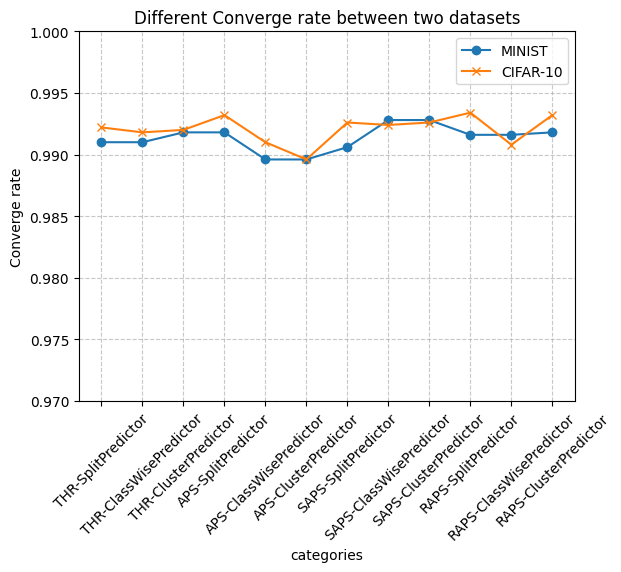

In [43]:
import matplotlib.pyplot as plt

# 示例数据
x = ['THR-SplitPredictor', 'THR-ClassWisePredictor', 'THR-ClusterPredictor', 'APS-SplitPredictor', 'APS-ClassWisePredictor', 'APS-ClusterPredictor', 'SAPS-SplitPredictor', 'SAPS-ClassWisePredictor', 'SAPS-ClusterPredictor', 'RAPS-SplitPredictor',
              'RAPS-ClassWisePredictor', 'RAPS-ClusterPredictor']
y1_values = [0.991,  0.991, 0.9918, 0.9918, 0.9896,0.9896,0.9906,0.9928,0.9928, 0.9916,0.9916,0.9918]
y2_values = [0.9922,  0.9918, 0.992, 0.9932, 0.991,0.9896,0.9926,0.9924,0.9926,0.9934,0.9908,0.9932]

# 第一条折线图
plt.plot(x, y1_values, label='MINIST', marker='o')

# 第二条折线图
plt.plot(x, y2_values, label='CIFAR-10', marker='x')

# 设置图例
plt.legend()

# 设置标题和标签
plt.title('Different Converge rate between two datasets')
plt.xlabel('categories')
plt.ylabel('Converge rate')
plt.ylim(0.97, 1)
# 设置 x 轴标签 45 度角度排列
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
# 显示图形
plt.show()

